# Spectral Reconstruction: Demonstration

In [1]:
import pickle
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
import spectral as spy
import imageio.v3 as iio

import scipy.integrate as integrate
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt

## Model Initialization

In [2]:
with open('models/CAVE_PR.pkl', 'rb') as file:
    model = pickle.load(file)

## Image Loading

In [3]:
path = Path('resources/benedict.jpg')

In [4]:
image = iio.imread(path)
height, width, _ = image.shape

## Image Reconstruction

In [5]:
hypercube = model.predict(image.reshape(-1, 3).astype(np.float64) / 255.0)
hypercube = hypercube.reshape(height, width, hypercube.shape[-1])

In [6]:
wavelengths = np.arange(400, 700 + 1, 10)

In [7]:
spy.envi.save_image(path.with_suffix('.hdr'), hypercube, force=True, metadata={
    'wavelength': wavelengths,
    'wavelength unit': 'nm',
})

## Illuminant Loading

In [8]:
d65_df = pd.read_csv('resources/illuminants/CIE_std_illum_D65.csv', header=None)
d65_w = d65_df[0].values
d65_i = d65_df[1].values

In [9]:
d65_i /= d65_i.max()
d65_i = interpolate.CubicSpline(d65_w, d65_i)(wavelengths)

In [10]:
d50_df = pd.read_csv('resources/illuminants/CIE_std_illum_D50.csv', header=None)
d50_w = d50_df[0].values
d50_i = d50_df[1].values

In [11]:
d50_i /= d50_i.max()
d50_i = interpolate.CubicSpline(d50_w, d50_i)(wavelengths)

## Synthesis: Sony IMX219

In [12]:
imx_df = pd.read_csv('resources/sensitivities/Sony_IMX219.csv')

In [13]:
imx_w = imx_df['Wavelength'].values
imx_r = imx_df['R'].values
imx_g = imx_df['G'].values
imx_b = imx_df['B'].values

In [14]:
imx_r = interpolate.CubicSpline(imx_w, imx_r)(wavelengths)
imx_g = interpolate.CubicSpline(imx_w, imx_g)(wavelengths)
imx_b = interpolate.CubicSpline(imx_w, imx_b)(wavelengths)

In [15]:
imx_r /= integrate.simpson(imx_r, wavelengths)
imx_g /= integrate.simpson(imx_g, wavelengths)
imx_b /= integrate.simpson(imx_b, wavelengths)

In [16]:
imx_image = np.zeros((height, width, 3))

for row in tqdm(range(height)):
    spectra = hypercube[row, :, :].astype(np.float64)
    imx_image[row, :, 0] = integrate.simpson(spectra * imx_r, wavelengths)
    imx_image[row, :, 1] = integrate.simpson(spectra * imx_g, wavelengths)
    imx_image[row, :, 2] = integrate.simpson(spectra * imx_b, wavelengths)

100%|██████████| 1279/1279 [00:00<00:00, 1382.17it/s]


In [17]:
imx_image[imx_image < 0] = 0
imx_image[imx_image > 1] = 1

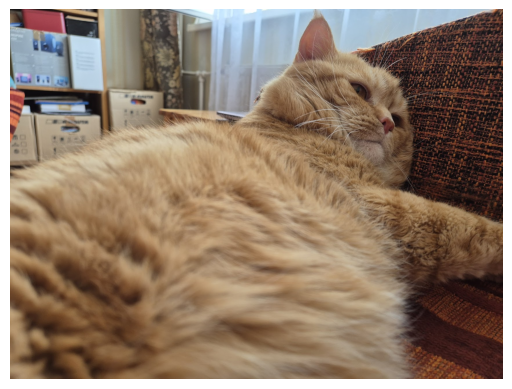

In [18]:
plt.axis('off')
plt.imshow(imx_image)
plt.show()

## Synthesis: Basler Ace 2

In [19]:
ace_df = pd.read_csv('resources/sensitivities/Basler_Ace2.csv')

In [20]:
ace_w = ace_df['Wavelength'].values
ace_r = ace_df['R'].values
ace_g = ace_df['G'].values
ace_b = ace_df['B'].values

In [21]:
ace_r = interpolate.CubicSpline(ace_w, ace_r)(wavelengths)
ace_g = interpolate.CubicSpline(ace_w, ace_g)(wavelengths)
ace_b = interpolate.CubicSpline(ace_w, ace_b)(wavelengths)

In [22]:
ace_r /= integrate.simpson(ace_r, wavelengths)
ace_g /= integrate.simpson(ace_g, wavelengths)
ace_b /= integrate.simpson(ace_b, wavelengths)

In [23]:
ace_image = np.zeros((height, width, 3))

for row in tqdm(range(height)):
    spectra = hypercube[row, :, :].astype(np.float64)
    ace_image[row, :, 0] = integrate.simpson(spectra * ace_r, wavelengths)
    ace_image[row, :, 1] = integrate.simpson(spectra * ace_g, wavelengths)
    ace_image[row, :, 2] = integrate.simpson(spectra * ace_b, wavelengths)

100%|██████████| 1279/1279 [00:00<00:00, 1392.47it/s]


In [24]:
ace_image[ace_image < 0] = 0
ace_image[ace_image > 1] = 1

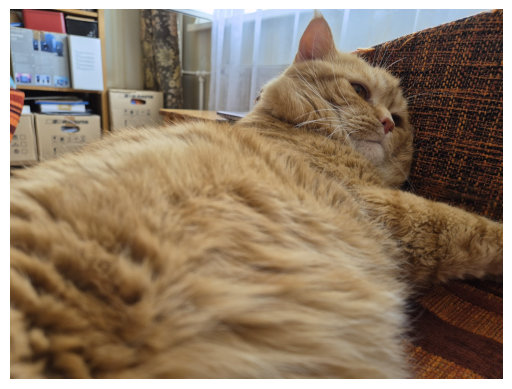

In [25]:
plt.axis('off')
plt.imshow(ace_image)
plt.show()

## Synthesis: CIE 1931

In [26]:
cie_df = pd.read_csv('resources/sensitivities/CIE_XYZ_1931.csv')

In [27]:
cie_w = cie_df['Wavelength'].values
cie_x = cie_df['X'].values
cie_y = cie_df['Y'].values
cie_z = cie_df['Z'].values

In [28]:
cie_x = interpolate.CubicSpline(cie_w, cie_x)(wavelengths)
cie_y = interpolate.CubicSpline(cie_w, cie_y)(wavelengths)
cie_z = interpolate.CubicSpline(cie_w, cie_z)(wavelengths)

In [29]:
k = 1.0 / integrate.simpson(d65_i * cie_y, wavelengths)

In [30]:
cie_xyz = np.zeros((height, width, 3))

for row in tqdm(range(height)):
    spectra = hypercube[row, :, :].astype(np.float64)
    cie_xyz[row, :, 0] = k * integrate.simpson(spectra * cie_x * d65_i, wavelengths)
    cie_xyz[row, :, 1] = k * integrate.simpson(spectra * cie_y * d65_i, wavelengths)
    cie_xyz[row, :, 2] = k * integrate.simpson(spectra * cie_z * d65_i, wavelengths)

100%|██████████| 1279/1279 [00:01<00:00, 1222.95it/s]


In [31]:
cie_srgb_transform = np.array([
    [+3.2404542, -1.5371385, -0.4985314],
    [-0.9692660, +1.8760108, +0.0415560],
    [+0.0556434, -0.2040259, +1.0572252],
])

In [32]:
cie_image = cie_srgb_transform @ cie_xyz.reshape(-1, 3).T
cie_image = cie_image.T.reshape(height, width, 3)

In [33]:
cie_image[cie_image > 1] = 1
cie_image[cie_image < 0] = 0

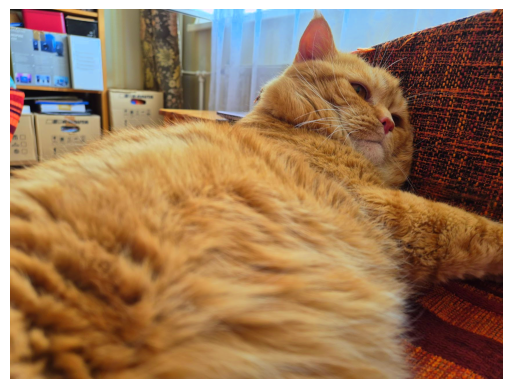

In [34]:
plt.axis('off')
plt.imshow(cie_image)
plt.show()

## Synthesis: Comparison

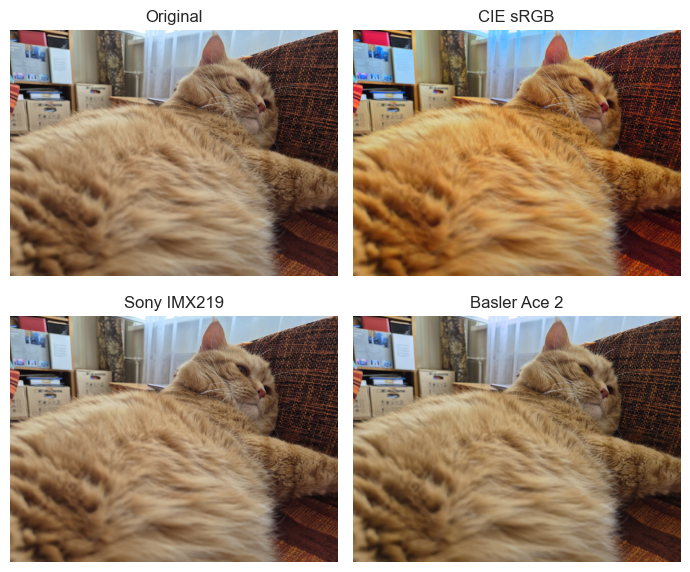

In [35]:
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 6))

axes[0, 0].set_title('Original')
axes[0, 0].axis('off')
axes[0, 0].imshow(image)

axes[0, 1].set_title('CIE sRGB')
axes[0, 1].axis('off')
axes[0, 1].imshow(cie_image)

axes[1, 0].set_title('Sony IMX219')
axes[1, 0].axis('off')
axes[1, 0].imshow(imx_image)

axes[1, 1].set_title('Basler Ace 2')
axes[1, 1].axis('off')
axes[1, 1].imshow(ace_image)

plt.tight_layout()
plt.show()

## Relighting: D65

In [36]:
d65_image = np.zeros((height, width, 3))

for row in tqdm(range(height)):
    spectra = hypercube[row, :, :].astype(np.float64)
    d65_image[row, :, 0] = integrate.simpson(spectra * imx_r * d65_i, wavelengths)
    d65_image[row, :, 1] = integrate.simpson(spectra * imx_g * d65_i, wavelengths)
    d65_image[row, :, 2] = integrate.simpson(spectra * imx_b * d65_i, wavelengths)

100%|██████████| 1279/1279 [00:01<00:00, 1217.86it/s]


In [37]:
d65_image[d65_image > 1] = 1
d65_image[d65_image < 0] = 0

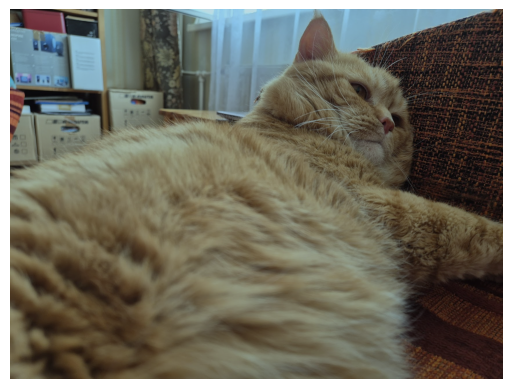

In [38]:
plt.axis('off')
plt.imshow(d65_image)
plt.show()

## Relighting: D50

In [39]:
d50_image = np.zeros((height, width, 3))

for row in tqdm(range(height)):
    spectra = hypercube[row, :, :].astype(np.float64)
    d50_image[row, :, 0] = integrate.simpson(spectra * imx_r * d50_i, wavelengths)
    d50_image[row, :, 1] = integrate.simpson(spectra * imx_g * d50_i, wavelengths)
    d50_image[row, :, 2] = integrate.simpson(spectra * imx_b * d50_i, wavelengths)

100%|██████████| 1279/1279 [00:01<00:00, 1260.07it/s]


In [40]:
d50_image[d50_image > 1] = 1
d50_image[d50_image < 0] = 0

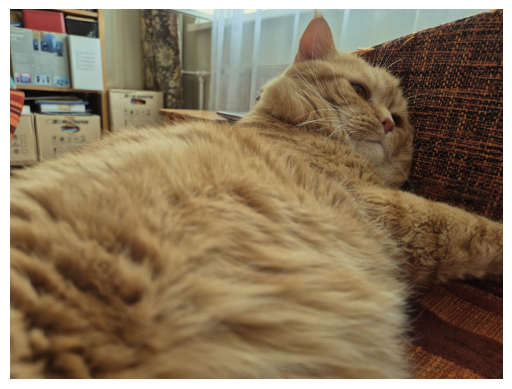

In [41]:
plt.axis('off')
plt.imshow(d50_image)
plt.show()

## Relighting: Comparison

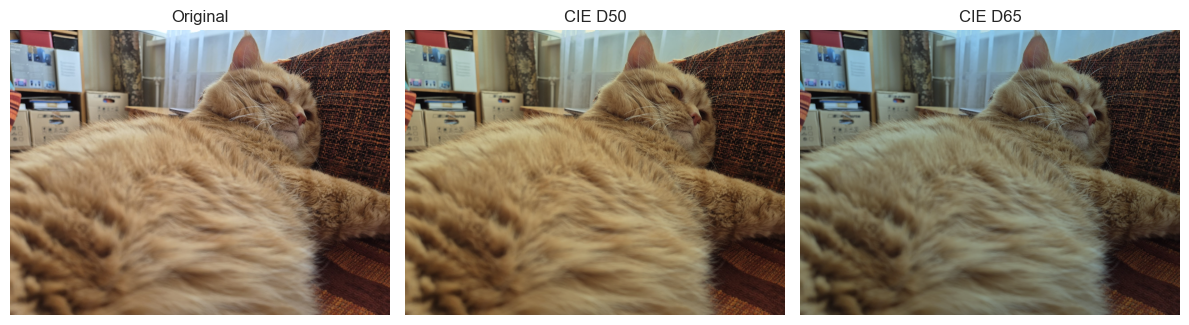

In [42]:
_, axes = plt.subplots(ncols=3, figsize=(12, 14))

axes[0].set_title('Original')
axes[0].axis('off')
axes[0].imshow(image)

axes[1].set_title('CIE D50')
axes[1].axis('off')
axes[1].imshow(d50_image)

axes[2].set_title('CIE D65')
axes[2].axis('off')
axes[2].imshow(d65_image)

plt.tight_layout()
plt.show()